In [1]:
from self_supervised_halos.utils.utils import data_preprocess_path, check_cuda
from self_supervised_halos.scripts.halo_mass_embeddings import mask_time_series_batch, RegressionModel

from self_supervised_halos.utils.dataloader import HaloDataset, img2d_transform, subhalos_df, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

device = check_cuda()

Running on local machine
matplotlib settings set
CUDA is not available.
Device: cpu


In [2]:
dataset = HaloDataset(root_dir=data_preprocess_path,subhalos_df=subhalos_df, load_2d=False, load_3d=False, load_mass=True,)

Preparing mass data: 100%|██████████| 16544/16544 [00:17<00:00, 952.52it/s] 


In [3]:
if device=='cpu':
    batch_size = 128
else:
    print('dataloader on gpu')
    batch_size = 512

print(f'Batch size: {batch_size}')

n_data = len(dataset)
f_train = 0.6
f_val = 0.2
f_test = 1 - f_train - f_val


train_size = int(f_train*len(dataset))
val_size = int(f_val*len(dataset))
test_size = len(dataset) - train_size - val_size


trainval_ds, test_ds = torch.utils.data.random_split(dataset, [train_size+val_size, test_size])
train_size = int(f_train/(f_train+f_val)*len(trainval_ds))
val_size = len(trainval_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(trainval_ds, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


Batch size: 128


In [4]:
lr = 1e-3
n_epochs=10


criterion = nn.MSELoss()

model = RegressionModel(
                    optimizer_class=torch.optim.Adam,
                    optimizer_params={'lr':lr},
                    scheduler_class=torch.optim.lr_scheduler.StepLR,
                    scheduler_params={'step_size':15, 'gamma':0.5},
                    criterion=criterion,
                    history=None,
                    transform=mask_time_series_batch,
)

model.load('Regression_1d.pth')


Model HaloMassHistTransformer not found at /Users/sdbykov/work/self_supervised_halos//results/models/Regression_1d.pth


/Users/sdbykov/opt/miniconda3/envs/venv_hea/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
model.trial_forward_pass(train_loader, device)

Trial Forward Pass limit_to_first_batch=True:   0%|          | 0/78 [00:00<?, ?it/s]

Loss: 0.8204856514930725
Trial forward pass elapsed time: 0.14 s (limit_to_first_batch=True)


Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]

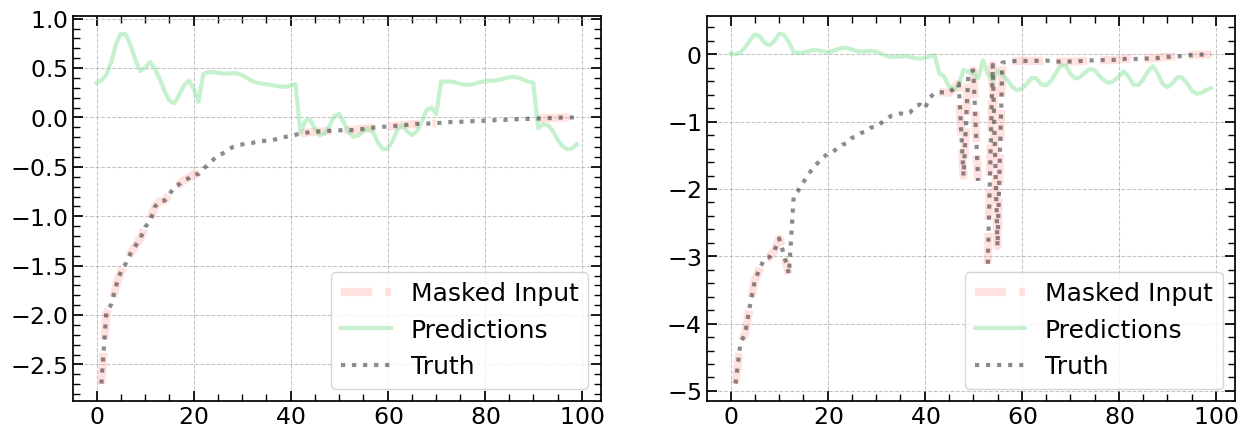

Trial Forward Pass:   0%|          | 0/78 [00:00<?, ?it/s]


In [6]:
model.show_transforms(train_loader, device)

In [7]:
model.training_loop(
    train_loader=train_loader, 
    val_loader=val_loader,
    num_epochs=n_epochs, 
    device=device)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.3058508260127826


Epochs:  10%|█         | 1/10 [00:22<03:18, 22.02s/it]

Epoch 1, Validation Loss: 0.22957622489103904
Epoch 2, Training Loss: 0.17307786748577386


Epochs:  20%|██        | 2/10 [00:48<03:15, 24.46s/it]

Epoch 2, Validation Loss: 0.06744332826481415
Epoch 3, Training Loss: 0.0791701135249474


Epochs:  30%|███       | 3/10 [01:12<02:50, 24.38s/it]

Epoch 3, Validation Loss: 0.05379176884889603
Epoch 4, Training Loss: 0.065797197417571


Epochs:  40%|████      | 4/10 [01:42<02:40, 26.72s/it]

Epoch 4, Validation Loss: 0.04677561914118437
Epoch 5, Training Loss: 0.06159507144147005


Epochs:  50%|█████     | 5/10 [02:14<02:23, 28.66s/it]

Epoch 5, Validation Loss: 0.04466444304069647
Epoch 6, Training Loss: 0.05629528858340704


Epochs:  60%|██████    | 6/10 [02:43<01:55, 28.76s/it]

Epoch 6, Validation Loss: 0.04442507644685415
Epoch 7, Training Loss: 0.05710026636146582


Epochs:  70%|███████   | 7/10 [03:14<01:28, 29.41s/it]

Epoch 7, Validation Loss: 0.0431804543790909
Epoch 8, Training Loss: 0.05313810538978149


Epochs:  80%|████████  | 8/10 [03:39<00:56, 28.07s/it]

Epoch 8, Validation Loss: 0.04317683482972475
Epoch 9, Training Loss: 0.05274594536958597


Epochs:  90%|█████████ | 9/10 [04:03<00:26, 26.61s/it]

Epoch 9, Validation Loss: 0.04151379503309727
Epoch 10, Training Loss: 0.051964230357836455


Epochs: 100%|██████████| 10/10 [04:26<00:00, 26.67s/it]

Epoch 10, Validation Loss: 0.04132043978629204


In [8]:
model.save()

Model HaloMassHistTransformer saved at epoch 10


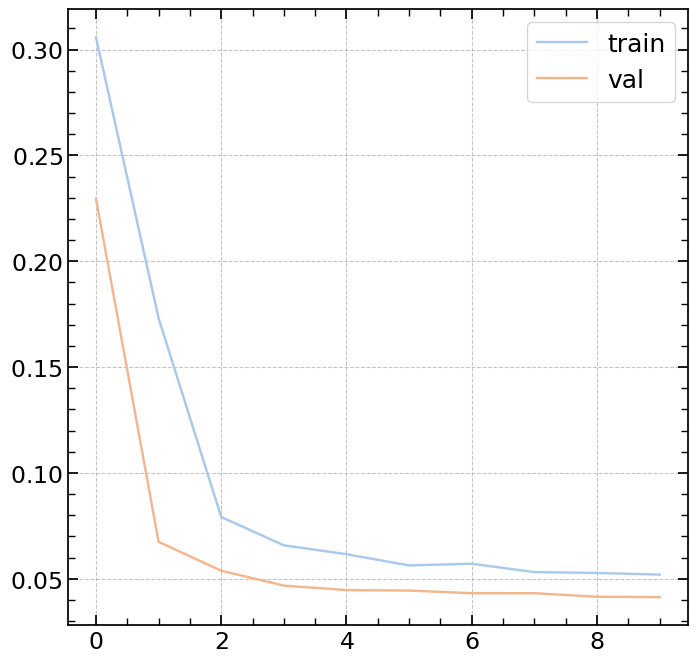

In [9]:
%matplotlib inline
plt.plot(model.history['train_loss'], label='train')
plt.plot(model.history['val_loss'], label='val')
plt.legend()
plt.show()

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]

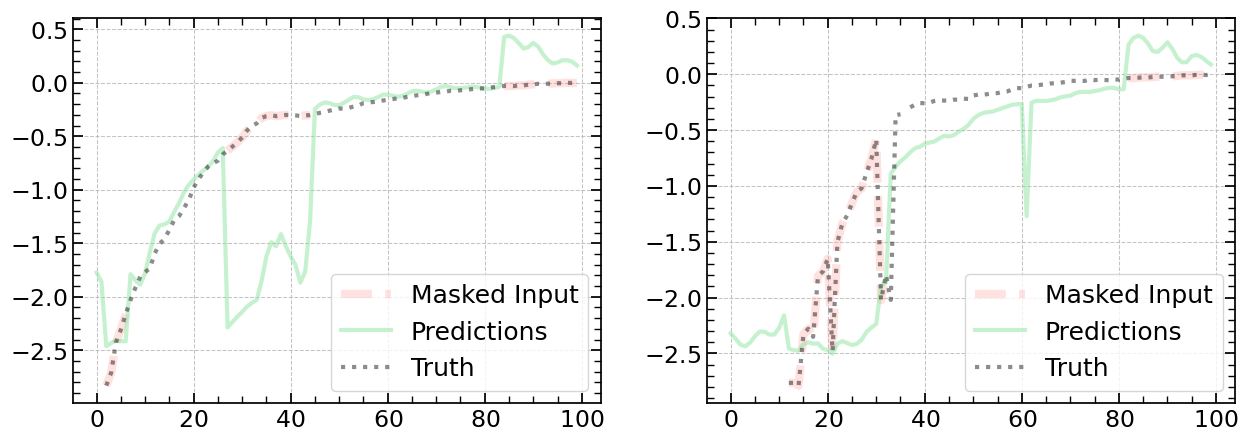

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]


In [10]:
model.show_transforms(test_loader, device)

Trial Forward Pass:   0%|          | 0/26 [00:00<?, ?it/s]

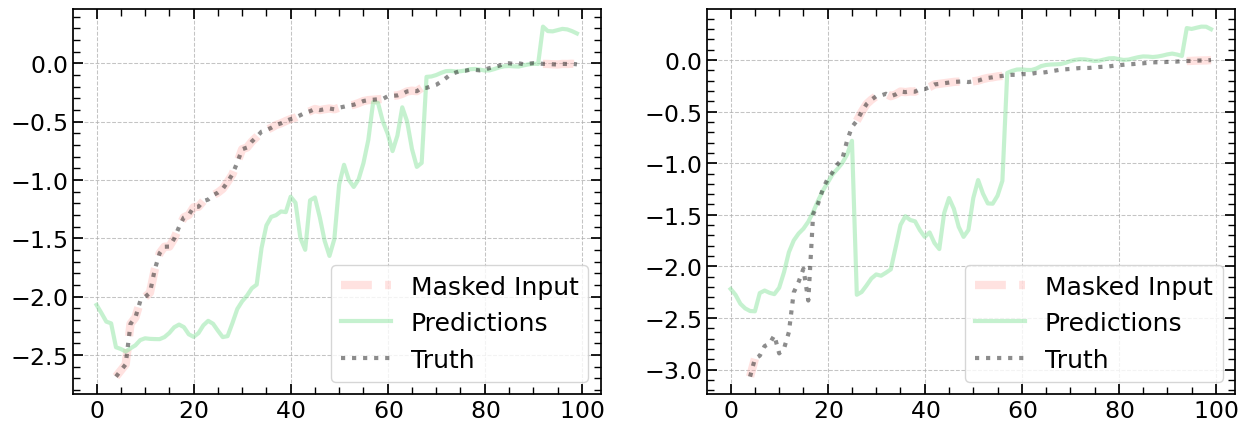

Trial Forward Pass:   0%|          | 0/26 [00:01<?, ?it/s]


In [11]:
model.show_transforms(test_loader, device)

In [14]:
tmp_batch

[[tensor([[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
        

In [109]:
#tmp_batch = next(iter(test_loader))

tmp_unmasked_signal, tmp_masked_signal, tmp_prediction_mask = mask_time_series_batch(tmp_batch[0][2].float(), mask_only_nans = True)

tmp_masked_signal_filled = torch.nan_to_num(tmp_masked_signal, nan=-10000.0)
src_key_padding_mask = torch.isnan(tmp_masked_signal)

output, hidden = model.model(tmp_masked_signal_filled, src_key_padding_mask)

In [112]:
src_key_padding_mask[0]

tensor([ True,  True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [110]:
output[0]

tensor([-0.4760, -0.4760, -0.4760, -2.4952, -2.4811, -2.4955, -2.5032, -2.4992,
        -2.4698, -2.4457, -2.4260, -2.4353, -2.4317, -2.4432, -2.4264, -2.3963,
        -2.3712, -2.3592, -2.3856, -2.4346, -2.4603, -2.4361, -2.3827, -2.3549,
        -2.3783, -2.4176, -2.4294, -2.4235, -2.3368, -2.0254, -2.1537, -2.0960,
        -2.0610, -1.9822, -1.7627, -1.5323, -1.4846, -1.6390, -1.3717, -1.2472,
        -1.2103, -1.4843, -1.7315, -1.8195, -1.4080, -1.3295, -1.1444, -1.1704,
        -1.7541, -1.6568, -1.3226, -1.1091, -1.1766, -1.2487, -1.2379, -1.1045,
        -0.8613, -0.4795, -0.4807, -0.6678, -0.8487, -1.0103, -0.8146, -0.4991,
        -0.6020, -0.8313, -1.0864, -1.1203, -0.7269, -0.3022, -0.2814, -0.2606,
        -0.2036, -0.2162, -0.1037,  0.0868,  0.2400,  0.2993,  0.2958,  0.2754,
         0.2697,  0.3045,  0.3650,  0.4222,  0.4631,  0.4436,  0.3967,  0.3807,
         0.3637,  0.3760,  0.3808,  0.3226,  0.2508,  0.2138,  0.2091,  0.2287,
         0.2407,  0.2343,  0.2159,  0.19

In [107]:
output[0]

tensor([-2.4840, -2.5183, -2.5503, -2.4952, -2.4811, -2.4955, -2.5032, -2.4992,
        -2.4698, -2.4457, -2.4260, -2.4353, -2.4317, -2.4432, -2.4264, -2.3963,
        -2.3712, -2.3592, -2.3856, -2.4346, -2.4603, -2.4361, -2.3827, -2.3549,
        -2.3783, -2.4176, -2.4294, -2.4235, -2.3368, -2.0254, -2.1537, -2.0960,
        -2.0610, -1.9822, -1.7627, -1.5323, -1.4846, -1.6390, -1.3717, -1.2472,
        -1.2103, -1.4843, -1.7315, -1.8195, -1.4080, -1.3295, -1.1444, -1.1704,
        -1.7541, -1.6568, -1.3226, -1.1091, -1.1766, -1.2487, -1.2379, -1.1045,
        -0.8613, -0.4795, -0.4807, -0.6678, -0.8487, -1.0103, -0.8146, -0.4991,
        -0.6020, -0.8313, -1.0864, -1.1203, -0.7269, -0.3022, -0.2814, -0.2606,
        -0.2036, -0.2162, -0.1037,  0.0868,  0.2400,  0.2993,  0.2958,  0.2754,
         0.2697,  0.3045,  0.3650,  0.4222,  0.4631,  0.4436,  0.3967,  0.3807,
         0.3637,  0.3760,  0.3808,  0.3226,  0.2508,  0.2138,  0.2091,  0.2287,
         0.2407,  0.2343,  0.2159,  0.19

In [103]:
tmp_unmasked_signal

tensor([[        nan,         nan,         nan,  ..., -3.6714e-03,
          0.0000e+00, -1.0878e-03],
        [        nan,         nan, -2.7679e+00,  ..., -4.3865e-03,
         -2.5935e-03,  0.0000e+00],
        [        nan,         nan, -2.5996e+00,  ..., -3.0207e-03,
         -4.6284e-03,  0.0000e+00],
        ...,
        [        nan, -2.8535e+00, -2.0996e+00,  ..., -8.1849e-03,
         -6.4867e-03,  0.0000e+00],
        [        nan,         nan, -2.9904e+00,  ..., -1.1390e-02,
         -5.8641e-03,  0.0000e+00],
        [        nan, -4.2356e+00, -3.4840e+00,  ..., -2.8185e-03,
         -4.5784e-03, -2.0446e-03]])

In [101]:
src_key_padding_mask = src_key_padding_mask.t()

hidden_states = hidden * (~src_key_padding_mask).unsqueeze(-1)  # Mask out padding tokens
embeddings = hidden_states.sum(dim=0) / (~src_key_padding_mask).sum(dim=0).unsqueeze(-1)

In [102]:
hidden_np = hidden_states.detach().cpu().numpy()
src_key_padding_mask_np = src_key_padding_mask.detach().cpu().numpy()

i = 127
tmp = hidden_np[:,i,:]
tmp = tmp[~src_key_padding_mask_np[:,i]]
tmp_m = tmp.mean(axis = 0)

print(embeddings[i].detach().cpu().numpy()/ tmp_m)

[1.         1.0000002  1.         1.0000002  1.0000005  1.0000001
 0.99999964 1.0000001  0.99999946 1.         1.0000002  0.9999999
 1.         0.9999998  0.9999999  1.0000002 ]


----